<h3> Importing the libraries

In [1]:
import time
import datetime
%pylab inline
import  pickle
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pylab
import re
import scipy as sp
import seaborn
from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Populating the interactive namespace from numpy and matplotlib


In [77]:
!pip install nbconvert

In [82]:
#setting the figure usibg seaborn
plt.rc('figure', figsize=(10,6))
seaborn.set()
colors = seaborn.color_palette()

<h3> Data loading and preprocessing

In [86]:
#reading yelp data provided at the yelp official website
user_data = pd.read_csv('yelp_user.csv',encoding='utf8')
business_data = pd.read_csv('yelp_business.csv')
checkin_data = pd.read_csv('yelp_checkin.csv')
review_data = pd.read_csv('yelp_review.csv')
tip_data = pd.read_csv('yelp_tip.csv')

In [4]:
user_data.head()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,...,0,0,0,0,0,0,0,0,1,0


In [5]:
review_user_data = review_data.merge(user_data,
                                     left_on='user_id',
                                     right_on='user_id',
                                     how='outer',
                                     suffixes=('_review', '_user'))

In [6]:
review_user_data.head()

,review_id,user_id,business_id,stars,date,text,useful_review,funny_review,cool_review,name,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,Tim,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,Tim,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,Tim,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,Tim,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
business_review_user_data = review_user_data.merge(business_data,
                                                   left_on='business_id',
                                                   right_on='business_id',
                                                   how='outer',
                                                   suffixes=('_reviewuser', '_business'))

In [8]:
business_review_user_data = business_review_user_data.rename(columns = {'name_reviewuser':'name_user',
                                                                        'review_count_reviewuser':'review_count_user',
                                                                        'stars_reviewuser':'stars_review'})

In [9]:
#features to be used
columns = business_review_user_data.columns
print(columns)

Index(['review_id', 'user_id', 'business_id', 'stars_review', 'date', 'text',
       'useful_review', 'funny_review', 'cool_review', 'name_user',
       'review_count_user', 'yelping_since', 'friends', 'useful_user',
       'funny_user', 'cool_user', 'fans', 'elite', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos', 'name_business',
       'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude',
       'longitude', 'stars_business', 'review_count_business', 'is_open',
       'categories'],
      dtype='object')


In [87]:
index_of_col= columns.get_loc('business_id')

In [11]:
cols = business_review_user_data.columns
cols = cols.map(lambda x: x.replace(' ', '_').lower() if isinstance(x, (str,str)) else x)
business_review_user_data.columns = cols
firstFewRows = business_review_user_data.iloc[:,[41,5,3,2]]
firstFewRowsList = firstFewRows['categories'].tolist()
restaurantsDF = firstFewRows[firstFewRows['categories'].str.contains('Restaurants')]

Text(0, 0.5, 'Number of reviews')

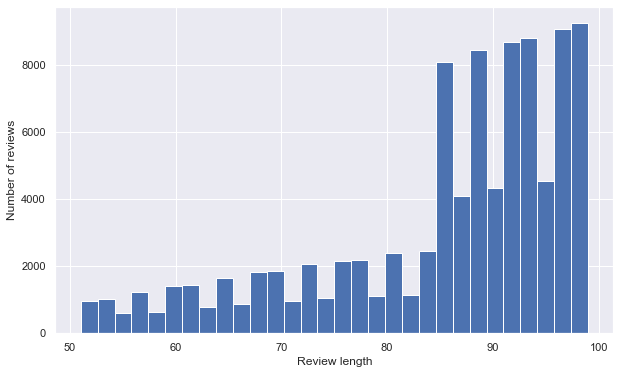

In [91]:
restaurantsDF.text.dropna().str.len().hist(bins=30)
xlabel('Review length')
ylabel('Number of reviews')

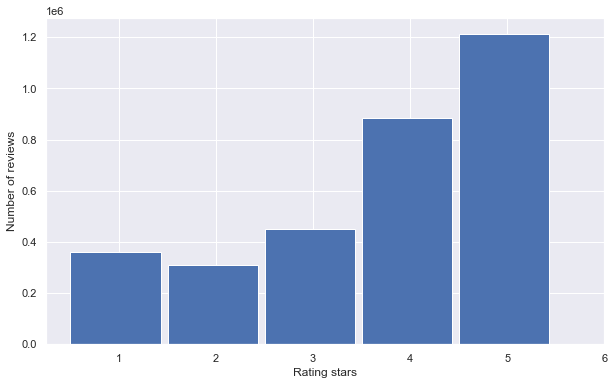

In [14]:
bins = [1, 2,3 ,4, 5, 6]
restaurantsDF.stars_review.hist(bins=bins, align='left', width=0.93)
xticks(bins)
xlabel('Rating stars')
ylabel('Number of reviews')
plt.show()

In [19]:
#function to plot the metrics
def central_tendency_plot(point, ci, y, color, label):
    plt.plot(ci, [y, y], "-", color=color, linewidth=4, label=label)
    plt.plot(point, y, "o", color=color, markersize=10)
    
def plot_error_dist(column, name):
    d = column.tolist()
    d = [0 if math.isnan(x) else x for x in d]
    m = mean(d)
    med = median(d)
    s = std(d)

    x = linspace(min(d), max(d), 1000)
    gauss = lambda x, m, s: (1 / (s * sqrt(2 * pi)) * exp(-0.5 * ((x - m) / s) ** 2))
    y = gauss(x, m, s)

    bins = np.arange(min(d), max(d)+1, 1)
    n, b, patches = plt.hist(d, bins=bins+1, density=True, align='left', width=0.95)
    xticks(bins)
    bin_max = np.max(n)
    m_y = bin_max/5
    
    central_tendency_plot(m, [m - s, m + s], m_y, colors[1], "std dev")

    ci = np.percentile(d, [16, 84])
    central_tendency_plot(med, ci,  m_y - bin_max/10, colors[2], "68% CI")
    
    plt.legend(loc=0)
    plt.plot(x, y, color=colors[4])
    plt.xlabel('Error')
    plt.ylabel('Normalized Frequency')
    title = name + ' Error Distribution'
    plt.title(title)
    plt.show()

In [20]:
restaurantsDF.loc['predicted_rating'] = round(sum(restaurantsDF.stars_review)/len(restaurantsDF.index))

In [21]:
restaurantsDF.loc['predicted_rating'] = round(sum(restaurantsDF.stars_review)/len(restaurantsDF.index))

print ("Baseline Rating:", round(sum(restaurantsDF.stars_review)/len(restaurantsDF.index)))

Baseline Rating: 4


<h3> Preparing and preprocessing the reviews </h3>

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ishu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
stoplist = set(stopwords.words("english"))

In [26]:
numTopics = 15

In [27]:
t = restaurantsDF.dropna(how='all')

In [28]:
minReviewLen = 50
maxReviewLen = 100

print ("Number of rows selected:",len(t[t.text.str.len() > minReviewLen][t.text.str.len() < maxReviewLen]))
restaurantsDF = t[t.text.str.len() > minReviewLen][t.text.str.len() < maxReviewLen]

C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Number of rows selected: 95017


C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [29]:
#function to create the list of reviews after preprocessing
def perform_lda(allReviewsTrain, numTopics):
    corpus = []
    for review in allReviewsTrain:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            corpus.append(texts)
        except:
            pass

    dictionary = corpora.Dictionary(corpus)
    dictionary.save('restaurant_reviews.dict')
        
    # Build vectorized corpus
    corpus_2 = [dictionary.doc2bow(text) for text in corpus]
    
    lda = models.LdaModel(corpus_2, num_topics=numTopics, id2word=dictionary)
    return lda

### Process the reviews and generate a topic distribution matrix (to be used as features in classification)

In [30]:
def process_reviews(dirty_data_set):
    clean_data_set = []
    for review in dirty_data_set:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            clean_data_set.append(' '.join(texts))
        except:
            pass
    return clean_data_set

# Generates a matrix of topic probabilities for each document in matrix
# Returns topic_dist for the input corpus, and all_dist, a running sum of all the corpuses
def generate_topic_dist_matrix(lda, numTopics, corpus, all_dist, star):
    topic_dist = [0] * numTopics
    dictionary = corpora.Dictionary.load("restaurant_reviews.dict")
    for doc in corpus:
        vec = dictionary.doc2bow(doc.lower().split())
        output = lda[vec]
        highest_prob = 0
        highest_topic = 0
        temp = [0] * numTopics    # List to keep track of topic distribution for each document
        for topic in output:
            this_topic, this_prob = topic
            temp[this_topic] = this_prob
            if this_prob > highest_prob:
                highest_prob = this_prob 
                highest_topic = this_topic
        temp.append(star)
        all_dist.append(temp)
        topic_dist[highest_topic] += 1
    return topic_dist, all_dist

### Construct 5 groups for each rating

In [31]:
starsGroup = restaurantsDF.groupby('stars_review')

all_1stars_text = starsGroup.get_group(1.0)['text']
all_2stars_text = starsGroup.get_group(2.0)['text']
all_3stars_text = starsGroup.get_group(3.0)['text']
all_4stars_text = starsGroup.get_group(4.0)['text']
all_5stars_text = starsGroup.get_group(5.0)['text']

all_1stars_labels = [1.0]*len(all_1stars_text)
all_2stars_labels = [2.0]*len(all_2stars_text)
all_3stars_labels = [3.0]*len(all_3stars_text)
all_4stars_labels = [4.0]*len(all_4stars_text)
all_5stars_labels = [5.0]*len(all_5stars_text)

###Split into training and testing data randomly using sklearn's library

In [32]:
from sklearn.model_selection import train_test_split

all_1stars_text_train, all_1stars_text_test, all_1stars_labels_train, all_1stars_labels_test = train_test_split(all_1stars_text, all_1stars_labels, test_size=0.20)
all_2stars_text_train, all_2stars_text_test, all_2stars_labels_train, all_2stars_labels_test = train_test_split(all_2stars_text, all_2stars_labels, test_size=0.20)
all_3stars_text_train, all_3stars_text_test, all_3stars_labels_train, all_3stars_labels_test = train_test_split(all_3stars_text, all_3stars_labels, test_size=0.20)
all_4stars_text_train, all_4stars_text_test, all_4stars_labels_train, all_4stars_labels_test = train_test_split(all_4stars_text, all_4stars_labels, test_size=0.20)
all_5stars_text_train, all_5stars_text_test, all_5stars_labels_train, all_5stars_labels_test = train_test_split(all_5stars_text, all_5stars_labels, test_size=0.20)

In [33]:
# Process the reviews
corpus_5stars = process_reviews(all_5stars_text_train)
corpus_4stars = process_reviews(all_4stars_text_train)
corpus_3stars = process_reviews(all_3stars_text_train)
corpus_2stars = process_reviews(all_2stars_text_train)
corpus_1stars = process_reviews(all_1stars_text_train)

print( "Number of 5-star reviews after processing: ", len(corpus_5stars))
print( "Number of 4-star reviews after processing: ", len(corpus_4stars))
print ("Number of 3-star reviews after processing: ", len(corpus_3stars))
print ("Number of 2-star reviews after processing: ", len(corpus_2stars))
print ("Number of 1-star reviews after processing: ", len(corpus_1stars))

Number of 5-star reviews after processing:  39220
Number of 4-star reviews after processing:  20218
Number of 3-star reviews after processing:  6942
Number of 2-star reviews after processing:  3908
Number of 1-star reviews after processing:  5723


In [34]:
all_5_4_train = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_train = np.append(all_5_4_train, corpus_3stars)
all_5_4_3_2_train = np.append(all_5_4_3_train, corpus_2stars)
all_text_train = np.append(all_5_4_3_2_train, corpus_1stars)


In [35]:
%time lda = perform_lda(all_text_train, numTopics)

Wall time: 30.6 s


### Build the final data frame containing topic distribution for each set of rating

In [81]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []

topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars, topic_dist_list, 1)

cols = []
for i in range(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_train_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)


topic_dist_5stars[0:10]
topic_dist_list[0:10]

[[0, 0, 0, 0, 0.3189033, 0, 0, 0, 0, 0, 0, 0.22644585, 0, 0, 0.37464517, 5],
 [0, 0, 0, 0, 0, 0, 0.30839714, 0, 0, 0, 0, 0.41808975, 0, 0, 0.20078076, 5],
 [0, 0, 0.3536148, 0, 0.19772573, 0.34864756, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
 [0, 0, 0.22969708, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.12658669, 0, 0.5548195, 5],
 [0.12692483,
  0,
  0,
  0,
  0.1212704,
  0.12706646,
  0.15356323,
  0,
  0.15739654,
  0,
  0.13397631,
  0,
  0,
  0,
  0.113127284,
  5],
 [0.10903241,
  0,
  0.113899335,
  0,
  0.3608245,
  0,
  0,
  0,
  0,
  0,
  0.22015662,
  0,
  0,
  0,
  0.13547727,
  5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0.6576435, 0, 0, 0, 0.11701206, 0.13641785, 0, 5],
 [0, 0, 0, 0, 0.40392584, 0.36369735, 0, 0, 0, 0, 0, 0, 0.15237439, 0, 0, 5],
 [0,
  0,
  0.20570299,
  0,
  0.10736344,
  0,
  0,
  0,
  0,
  0,
  0,
  0.20633101,
  0.40713263,
  0,
  0,
  5],
 [0,
  0.2435902,
  0,
  0.40110055,
  0.16897298,
  0,
  0,
  0,
  0,
  0,
  0.11298228,
  0,
  0,
  0,
  0,
  5]]

Get topic distribution of test data.

In [37]:
# Process the test reviews
corpus_5stars = process_reviews(all_5stars_text_test)
corpus_4stars = process_reviews(all_4stars_text_test)
corpus_3stars = process_reviews(all_3stars_text_test)
corpus_2stars = process_reviews(all_2stars_text_test)
corpus_1stars = process_reviews(all_1stars_text_test)

print( "Number of 5-star reviews after processing: ", len(corpus_5stars))
print ("Number of 4-star reviews after processing: ", len(corpus_4stars))
print ("Number of 3-star reviews after processing: ", len(corpus_3stars))
print ("Number of 2-star reviews after processing: ", len(corpus_2stars))
print ("Number of 1-star reviews after processing: ", len(corpus_1stars))

Number of 5-star reviews after processing:  9806
Number of 4-star reviews after processing:  5055
Number of 3-star reviews after processing:  1736
Number of 2-star reviews after processing:  978
Number of 1-star reviews after processing:  1431


In [38]:
all_5_4_test = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_test = np.append(all_5_4_test, corpus_3stars)
all_5_4_3_2_test = np.append(all_5_4_3_test, corpus_2stars)
all_text_test = np.append(all_5_4_3_2_test, corpus_1stars)


In [39]:
topic_dist_list = []
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []


topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars, topic_dist_list, 1)

cols = []
for i in range(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_test_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)


In [40]:
topic_dist_test_1_2_3_4_5_df.shape

(19006, 16)

In [41]:
topic_dist_train_1_2_3_4_5_df.shape

(76011, 16)

<h5> Sentiment data </h5>

In [42]:
def getSentiment(x):
    if x < 3.5:
        return 0
    else:
        return 1

In [43]:
topic_dist_train_1_2_3_4_5_df['Sentiment'] = topic_dist_train_1_2_3_4_5_df['Star'].map(getSentiment)
topic_dist_test_1_2_3_4_5_df['Sentiment'] = topic_dist_test_1_2_3_4_5_df['Star'].map(getSentiment)

<h3> Naive Bayes model </h3>

In [45]:
vectorizer = TfidfVectorizer()

tfidfXtrain = vectorizer.fit_transform(all_text_train)
tfidfXtest = vectorizer.transform(all_text_test)

tfidfYtrain = topic_dist_train_1_2_3_4_5_df['Star']
tfidfYtest = topic_dist_test_1_2_3_4_5_df['Star']

In [46]:
print(tfidfYtest.shape)

(19006,)


In [47]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression()]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression']

NBResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(tfidfXtrain, tfidfYtrain)
    preds = clf.predict(tfidfXtest)
    
    precision = metrics.precision_score(tfidfYtest, preds,average='micro')
    recall = metrics.recall_score(tfidfYtest, preds,average='micro')
    f1 = metrics.f1_score(tfidfYtest, preds,average='micro')
    accuracy = accuracy_score(tfidfYtest, preds)
    report = classification_report(tfidfYtest, preds)
    matrix = metrics.confusion_matrix(list(tfidfYtest), list(preds), labels=list(starsGroup.groups.keys()))
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    NBResults[clf_names[i]] = data

cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(NBResults).T[cols].T

C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Nearest Neighbors,Multinomial Naive Bayes,Logistic Regression
precision,0.35936,0.565085,0.632642
recall,0.35936,0.565085,0.632642
f1_score,0.35936,0.565085,0.632642
accuracy,0.35936,0.565085,0.632642


In [48]:
for model, val in NBResults.items():
    print ('-------'+'-'*len(model))
    print ('MODEL:', model)
    print ('-------'+'-'*len(model))
    print ('The precision for this classifier is ' + str(val['precision']))
    print ('The recall for this classifier is    ' + str(val['recall']))
    print ('The f1 for this classifier is        ' + str(val['f1_score']))
    print ('The accuracy for this classifier is  ' + str(val['accuracy']))
    print ('Here is the classification report:')
    print (val['clf_report'])

------------------------
MODEL: Nearest Neighbors
------------------------
The precision for this classifier is 0.3593602020414606
The recall for this classifier is    0.3593602020414606
The f1 for this classifier is        0.3593602020414606
The accuracy for this classifier is  0.3593602020414606
Here is the classification report:
              precision    recall  f1-score   support

           1       0.16      0.13      0.14      1431
           2       0.08      0.03      0.04       978
           3       0.12      0.19      0.15      1736
           4       0.28      0.38      0.32      5055
           5       0.56      0.45      0.50      9806

    accuracy                           0.36     19006
   macro avg       0.24      0.23      0.23     19006
weighted avg       0.39      0.36      0.37     19006

------------------------------
MODEL: Multinomial Naive Bayes
------------------------------
The precision for this classifier is 0.56508471009155
The recall for this classifier

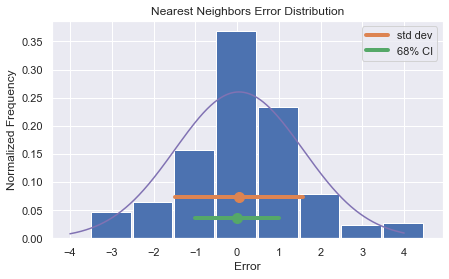

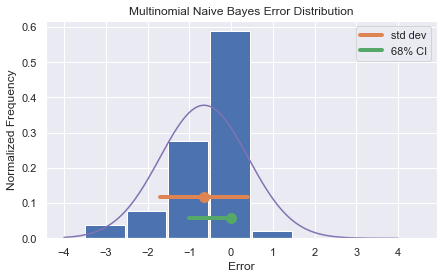

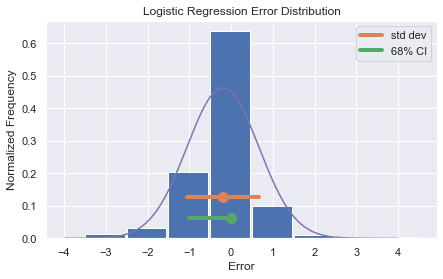

In [50]:
for model, val in NBResults.items():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    
    test_data = pd.DataFrame(y_predicted, columns=['predicted_rating'])
    test_data['rating'] = tfidfYtest

    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)

---
<h3> Model using data by  LDA </h3>

To reduce processing of redundant information that we did on term frequency method, we are using topic modeling to extract major topics in a review and using that as features.

In [51]:
features = list(topic_dist_train_1_2_3_4_5_df.columns[:numTopics])
print (features)

['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15']


In [52]:
x_train = topic_dist_train_1_2_3_4_5_df[features]
y_train = topic_dist_train_1_2_3_4_5_df['Star']

x_test = topic_dist_test_1_2_3_4_5_df[features]
y_test = topic_dist_test_1_2_3_4_5_df['Star'] 

clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), LDA(), QDA(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression', 'LDA', 'QDA', 'Random Forest', 'AdaBoost']

LDAResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    precision = metrics.precision_score(y_test, preds,average='micro')
    recall = metrics.recall_score(y_test, preds,average='micro')
    f1 = metrics.f1_score(y_test, preds,average='micro')
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(list(y_test),list(preds), labels=list(starsGroup.groups.keys()))
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    LDAResults[clf_names[i]] = data

C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\I

In [53]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(LDAResults).T[cols].T

,Nearest Neighbors,Multinomial Naive Bayes,Logistic Regression,LDA,QDA,Random Forest,AdaBoost
precision,0.408292,0.515942,0.515679,0.514417,0.453383,0.477586,0.514522
recall,0.408292,0.515942,0.515679,0.514417,0.453383,0.477586,0.514522
f1_score,0.408292,0.515942,0.515679,0.514417,0.453383,0.477586,0.514522
accuracy,0.408292,0.515942,0.515679,0.514417,0.453383,0.477586,0.514522


In [55]:
for model, val in LDAResults.items():
    print ('-------'+'-'*len(model))
    print ('MODEL:', model)
    print ('-------'+'-'*len(model))
    print ('The precision for this classifier is ' + str(val['precision']))
    print ('The recall for this classifier is    ' + str(val['recall']))
    print ('The f1 for this classifier is        ' + str(val['f1_score']))
    print ('The accuracy for this classifier is  ' + str(val['accuracy']))
    print ('Here is the classification report:')
    print (val['clf_report'])

------------------------
MODEL: Nearest Neighbors
------------------------
The precision for this classifier is 0.40829211827843837
The recall for this classifier is    0.40829211827843837
The f1 for this classifier is        0.40829211827843837
The accuracy for this classifier is  0.40829211827843837
Here is the classification report:
              precision    recall  f1-score   support

           1       0.11      0.09      0.10      1431
           2       0.08      0.05      0.06       978
           3       0.13      0.09      0.11      1736
           4       0.28      0.29      0.28      5055
           5       0.56      0.61      0.58      9806

    accuracy                           0.41     19006
   macro avg       0.23      0.23      0.23     19006
weighted avg       0.38      0.41      0.40     19006

------------------------------
MODEL: Multinomial Naive Bayes
------------------------------
The precision for this classifier is 0.5159423339997895
The recall for this clas

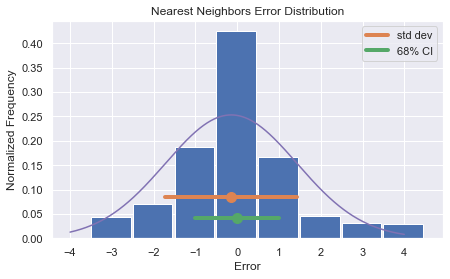

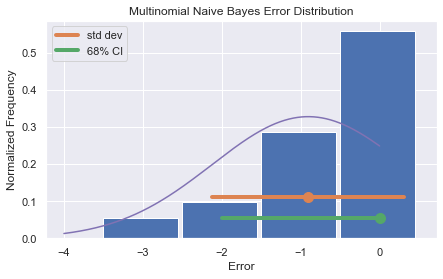

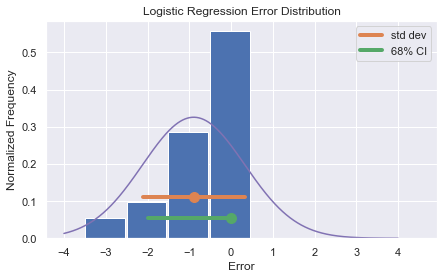

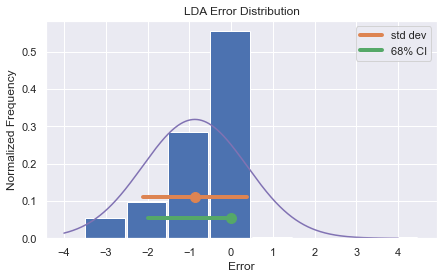

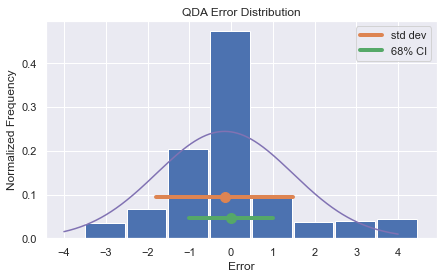

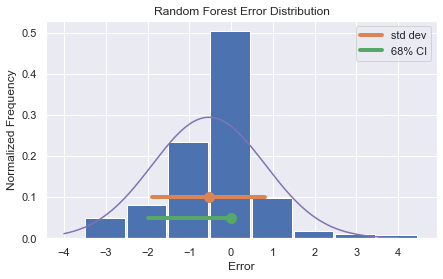

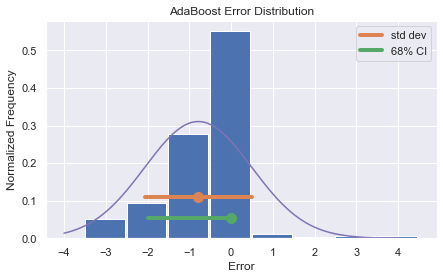

In [56]:
for model, val in LDAResults.items():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    
    test_data = pd.DataFrame(y_predicted, columns=['predicted_rating'])
    test_data['rating'] = tfidfYtest

    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)

<h3>Sentiment and LDA </H3>

In [57]:
sentimentXtrain = vectorizer.fit_transform(all_text_train)
sentimentXtest = vectorizer.transform(all_text_test)

sentimentYtrain = topic_dist_train_1_2_3_4_5_df['Sentiment']
sentimentYtest = topic_dist_test_1_2_3_4_5_df['Sentiment']

nb_classifier = LogisticRegression().fit(sentimentXtrain, sentimentYtrain)

ySentimentTrain = nb_classifier.predict(sentimentXtrain)
ySentimentTest = nb_classifier.predict(sentimentXtest)

topic_dist_train_1_2_3_4_5_df['Sentiment_Predicted'] = ySentimentTrain
topic_dist_test_1_2_3_4_5_df['Sentiment_Predicted'] = ySentimentTest

C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [74]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression()]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression']

SentimentResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(sentimentXtrain, sentimentYtrain)
    preds = clf.predict(sentimentXtest)
    
    precision = metrics.precision_score(sentimentYtest, preds,average ='micro')
    recall = metrics.recall_score(sentimentYtest, preds,average='micro')
    f1 = metrics.f1_score(sentimentYtest, preds,average='micro')
    accuracy = accuracy_score(sentimentYtest, preds)
    report = classification_report(sentimentYtest, preds)
    #matrix = metrics.confusion_matrix(sentimentYtest, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
     #       'clf_matrix':matrix,
            'y_predicted':preds}
    
    SentimentResults[clf_names[i]] = data
    
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(SentimentResults).T[cols].T

C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Nearest Neighbors,Multinomial Naive Bayes,Logistic Regression
precision,0.727297,0.867095,0.900295
recall,0.727297,0.867095,0.900295
f1_score,0.727297,0.867095,0.900295
accuracy,0.727297,0.867095,0.900295


In [75]:
for model, val in SentimentResults.items():
    print ('-------'+'-'*len(model))
    print ('MODEL:', model)
    print ('-------'+'-'*len(model))
    print ('The precision for this classifier is ' + str(val['precision']))
    print ('The recall for this classifier is    ' + str(val['recall']))
    print ('The f1 for this classifier is        ' + str(val['f1_score']))
    print ('The accuracy for this classifier is  ' + str(val['accuracy']))
    print ('Here is the classification report:')
    print (val['clf_report'])

------------------------
MODEL: Nearest Neighbors
------------------------
The precision for this classifier is 0.7272966431653162
The recall for this classifier is    0.7272966431653162
The f1 for this classifier is        0.7272966431653163
The accuracy for this classifier is  0.7272966431653162
Here is the classification report:
              precision    recall  f1-score   support

           0       0.31      0.20      0.24      4145
           1       0.80      0.87      0.83     14861

    accuracy                           0.73     19006
   macro avg       0.55      0.54      0.54     19006
weighted avg       0.69      0.73      0.70     19006

------------------------------
MODEL: Multinomial Naive Bayes
------------------------------
The precision for this classifier is 0.8670946017047249
The recall for this classifier is    0.8670946017047249
The f1 for this classifier is        0.8670946017047249
The accuracy for this classifier is  0.8670946017047249
Here is the classifica

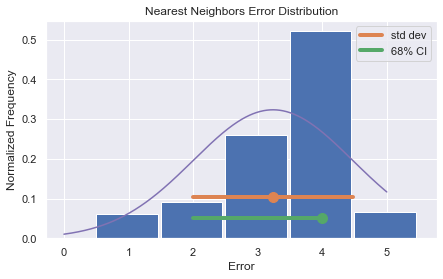

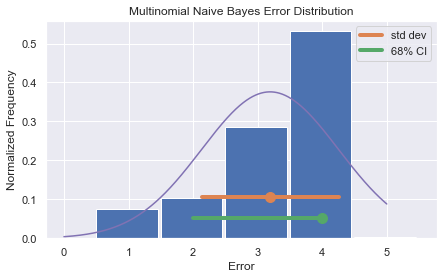

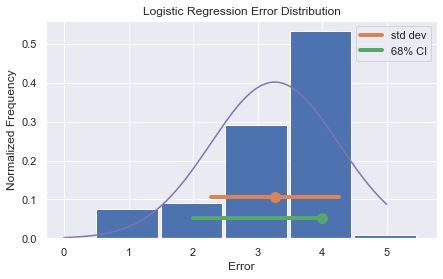

In [76]:
for model, val in SentimentResults.items():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    
    test_data = pd.DataFrame(y_predicted, columns=['predicted_rating'])
    test_data['rating'] = tfidfYtest

    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)

In [64]:
features = list(topic_dist_train_1_2_3_4_5_df.columns[:numTopics])
features.append(topic_dist_train_1_2_3_4_5_df.columns[numTopics+2])
print(features)

['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Sentiment_Predicted']


In [65]:
x_train = topic_dist_train_1_2_3_4_5_df[features]
y_train = topic_dist_train_1_2_3_4_5_df['Star']

x_test = topic_dist_test_1_2_3_4_5_df[features]
y_test = topic_dist_test_1_2_3_4_5_df['Star'] 

clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), LDA(), QDA(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression', 'LDA', 'QDA', 'Random Forest', 'AdaBoost']

FinalResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    precision = metrics.precision_score(y_test, preds,average='micro')
    recall = metrics.recall_score(y_test, preds,average='micro')
    f1 = metrics.f1_score(y_test, preds,average='micro')
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(list(y_test), list(preds), labels=list(starsGroup.groups.keys()))
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    FinalResults[clf_names[i]] = data

C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ishu\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\I

In [66]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(FinalResults).T[cols].T

,Nearest Neighbors,Multinomial Naive Bayes,Logistic Regression,LDA,QDA,Random Forest,AdaBoost
precision,0.499632,0.515942,0.574187,0.571556,0.555404,0.539882,0.567873
recall,0.499632,0.515942,0.574187,0.571556,0.555404,0.539882,0.567873
f1_score,0.499632,0.515942,0.574187,0.571556,0.555404,0.539882,0.567873
accuracy,0.499632,0.515942,0.574187,0.571556,0.555404,0.539882,0.567873


In [67]:
for model, val in FinalResults.items():
    print ('-------'+'-'*len(model))
    print ('MODEL:', model)
    print ('-------'+'-'*len(model))
    print ('The precision for this classifier is ' + str(val['precision']))
    print ('The recall for this classifier is    ' + str(val['recall']))
    print ('The f1 for this classifier is        ' + str(val['f1_score']))
    print ('The accuracy for this classifier is  ' + str(val['accuracy']))
    print ('Here is the classification report:')
    print (val['clf_report'])

------------------------
MODEL: Nearest Neighbors
------------------------
The precision for this classifier is 0.49963169525413026
The recall for this classifier is    0.49963169525413026
The f1 for this classifier is        0.49963169525413026
The accuracy for this classifier is  0.49963169525413026
Here is the classification report:
              precision    recall  f1-score   support

           1       0.42      0.56      0.48      1431
           2       0.22      0.16      0.18       978
           3       0.22      0.12      0.15      1736
           4       0.32      0.28      0.30      5055
           5       0.63      0.71      0.66      9806

    accuracy                           0.50     19006
   macro avg       0.36      0.36      0.36     19006
weighted avg       0.47      0.50      0.48     19006

------------------------------
MODEL: Multinomial Naive Bayes
------------------------------
The precision for this classifier is 0.5159423339997895
The recall for this clas

---

In [68]:
# Train Data
data_1stars_train = {"text": all_1stars_text_train, "rating": all_1stars_labels_train}
data_1stars_train = pd.DataFrame(data_1stars_train)

data_2stars_train = {"text": all_2stars_text_train, "rating": all_2stars_labels_train}
data_2stars_train = pd.DataFrame(data_2stars_train)

data_3stars_train = {"text": all_3stars_text_train, "rating": all_3stars_labels_train}
data_3stars_train = pd.DataFrame(data_3stars_train)

data_4stars_train = {"text": all_4stars_text_train, "rating": all_4stars_labels_train}
data_4stars_train = pd.DataFrame(data_4stars_train)

data_5stars_train = {"text": all_5stars_text_train, "rating": all_5stars_labels_train}
data_5stars_train = pd.DataFrame(data_5stars_train)

# Test Data
data_1stars_test = {"text": all_1stars_text_test, "rating": all_1stars_labels_test}
data_1stars_test = pd.DataFrame(data_1stars_test)

data_2stars_test = {"text": all_2stars_text_test, "rating": all_2stars_labels_test}
data_2stars_test = pd.DataFrame(data_2stars_test)

data_3stars_test = {"text": all_3stars_text_test, "rating": all_3stars_labels_test}
data_3stars_test = pd.DataFrame(data_3stars_test)

data_4stars_test = {"text": all_4stars_text_test, "rating": all_4stars_labels_test}
data_4stars_test = pd.DataFrame(data_4stars_test)

data_5stars_test = {"text": all_5stars_text_test, "rating": all_5stars_labels_test}
data_5stars_test = pd.DataFrame(data_5stars_test)

In [69]:
train_pieces = [data_1stars_train, data_2stars_train, data_3stars_train, data_4stars_train, data_5stars_train]
train_data = pd.concat(train_pieces, ignore_index=True)
train_data['predicted_rating'] = pd.Series('training_data', index=train_data.index)
print( "Train Data", len(train_data))

test_pieces = [data_1stars_test, data_2stars_test, data_3stars_test, data_4stars_test, data_5stars_test]
test_data = pd.concat(test_pieces, ignore_index=True)
print ("Test Data", len(test_data))

Train Data 76011
Test Data 19006


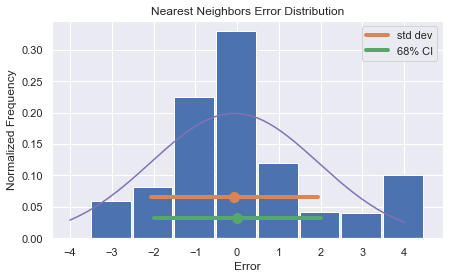

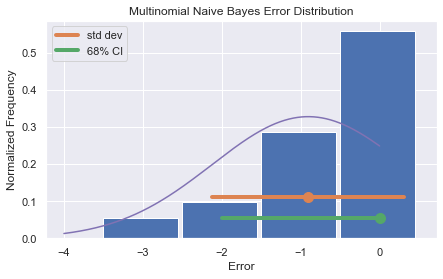

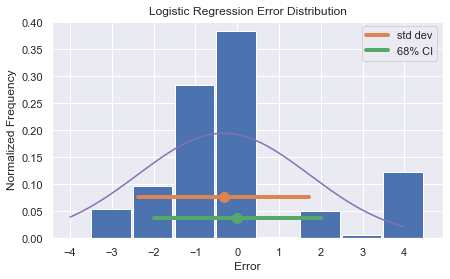

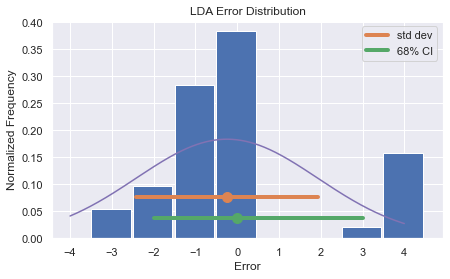

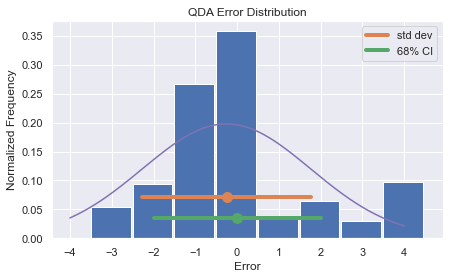

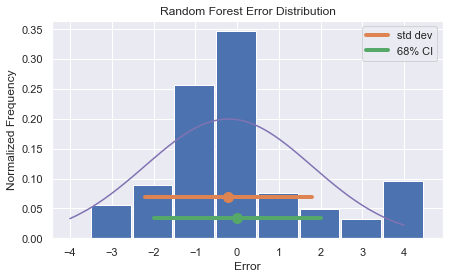

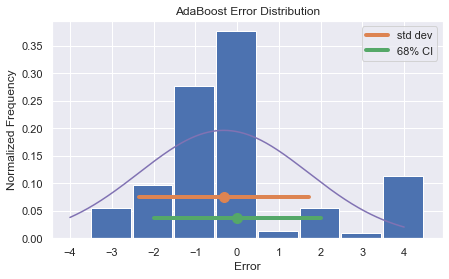

In [70]:
for model, val in FinalResults.items():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    test_data['predicted_rating'] = pd.Series(y_predicted)
    pieces = [train_data, test_data]
    all_data = pd.concat(pieces, ignore_index=True)
    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)